In [ ]:
import os

import yaml

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import astropy.table
import btk
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from galcheat.utilities import mag2counts, mean_sky_level
from numba import jit

from btksims.utils import get_btksims_config_path

In [ ]:
with open(get_btksims_config_path()) as f:
    btksims_config = yaml.safe_load(f)

In [ ]:
CATSIM_CATALOG_PATH = btksims_config["ORIGINAL_CAT_PATH"]

_, ext = os.path.splitext(CATSIM_CATALOG_PATH)
fmt = "fits" if ext.lower() == ".fits" else "ascii.basic"
catalog = astropy.table.Table.read(CATSIM_CATALOG_PATH, format=fmt)

(0.0, 2.0)

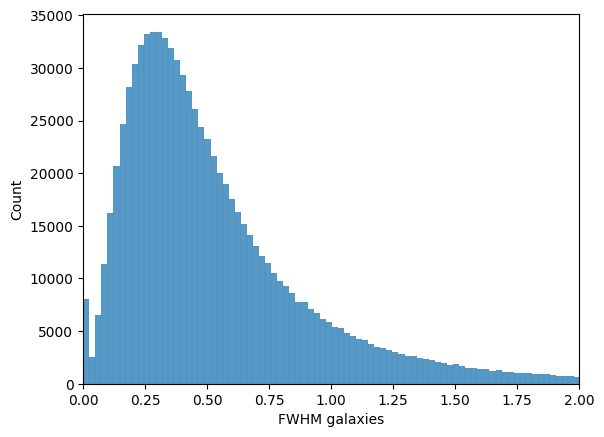

In [ ]:
ax = sns.histplot(2 * np.sqrt(catalog["a_d"] * catalog["b_d"]), bins=2000)
ax.set_xlabel("FWHM galaxies")
ax.set_xlim((0, 2))

# Compute SNR

In [ ]:
survey = btk.survey.get_surveys("LSST")
r_filter = survey.get_filter("r")

In [ ]:
snr = []

# For calculation of source counts (C) and mean_sky_level (B) refer to https://github.com/aboucaud/galcheat/blob/main/galcheat/utilities.py
# For Computaion of SNR, refer to: https://smtn-002.lsst.io/

# background noise
B = mean_sky_level("LSST", "r").to_value("electron")

# Assume gain = 1
g = 1

# compute sigma_instr https://smtn-002.lsst.io/
dark_current = 0.2
exp_time = 15  # 2 * 15 sec exposures
num_exp = 184 * 2  # 184 visits from: https://arxiv.org/pdf/0805.2366.pdf
read_noise = 8.8

sig_instr = np.sqrt((read_noise**2 + dark_current * exp_time) * num_exp)
# But BTK does not add instr noise (https://github.com/LSSTDESC/BlendingToolKit/blob/main/btk/draw_blends.py lines: 418-432)
sig_instr = 0  # ok to set it to 0 ??


@jit
def computeFWHM(hlr_a, hlr_b):
    return 2 * np.sqrt(
        hlr_a * hlr_b
    )  # fwhm = 2*hlr from: https://www.researchgate.net/publication/1778778_Accurate_photometry_of_extended_spherically_symmetric_sources/figures?lo=1


@jit
def compute_snr(C, B, FWHM_gal, FWHM_PSF=r_filter.psf_fwhm.value, sig_insrt=sig_instr):

    # convolve with PSF with FWHM of galaxy
    FWHM = np.sqrt(FWHM_gal**2 + FWHM_PSF**2)  # convolution of 2 PSF

    # Source footprint https://smtn-002.lsst.io/
    n_eff = 2.266 * ((FWHM / 0.2) ** 2)

    # compute_snr
    snr = C / np.sqrt(
        C + (B / g + sig_instr**2) * n_eff
    )  # from : https://smtn-002.lsst.io/
    return snr


for row in catalog:
    # Source counts
    C = mag2counts(row["r_ab"], "LSST", "r").to_value("electron")  # is this correct?

    # FWHM of galaxy
    FWHM_row_d = computeFWHM(row["a_d"], row["b_d"])
    FWHM_row_b = computeFWHM(row["a_b"], row["b_b"])
    FWHM_gal = FWHM_row_d if FWHM_row_d > FWHM_row_b else FWHM_row_b

    current_snr = compute_snr(C=C, B=B, FWHM_gal=FWHM_gal)

    snr.append(current_snr)

In [ ]:
snr = np.array(snr)

### Plot distribution of SNR

Text(0.5, 0, 'SNR')

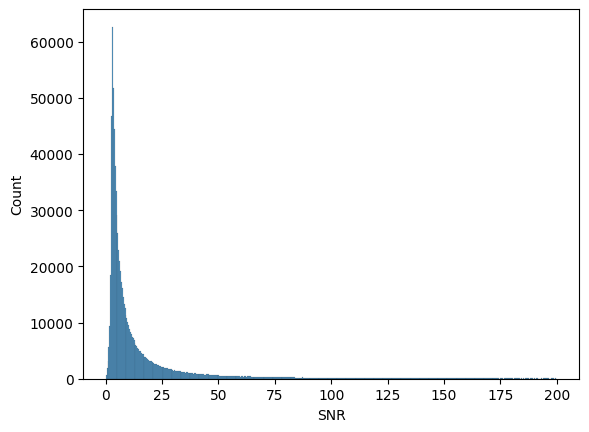

In [ ]:
sns.histplot(snr[snr <= 200], bins=500)
plt.xlabel("SNR")

Text(0.5, 0, 'SNR')

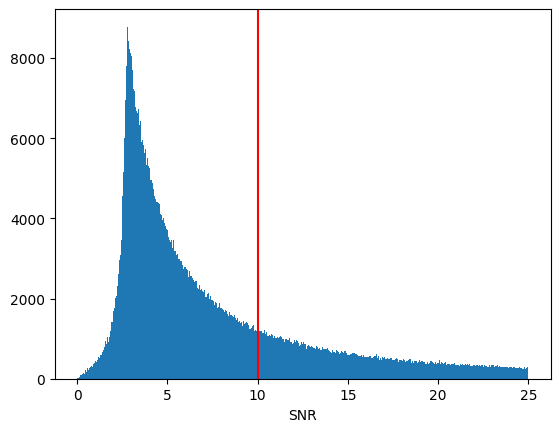

In [ ]:
plt.hist(snr[snr <= 25], bins=500)
plt.axvline(10, color="r")
plt.xlabel("SNR")

Text(0.5, 0, 'SNR')

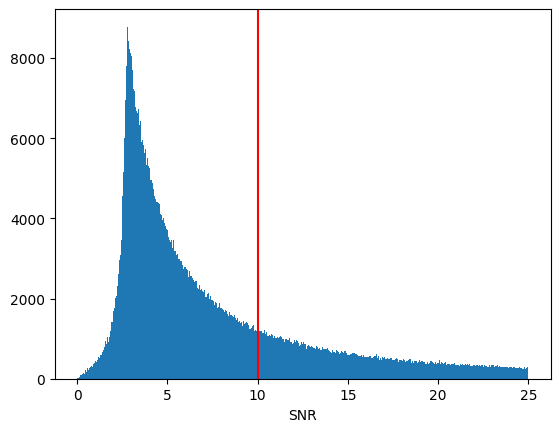

In [ ]:
plt.hist(snr[snr <= 25], bins=500)
plt.axvline(10, color="r")
plt.xlabel("SNR")

Text(0, 0.5, 'mag')

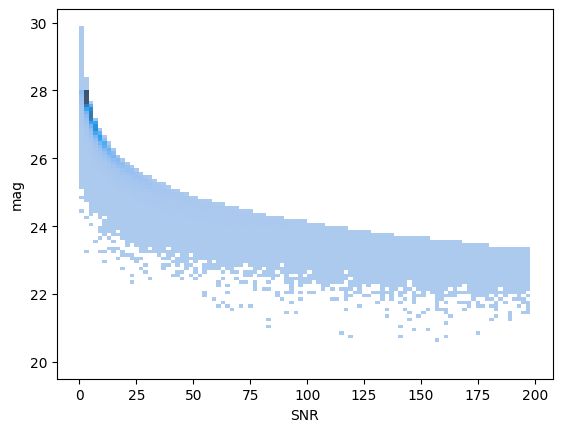

In [ ]:
x_bins = np.arange(0, 200, 200 / 100.0)
y_bins = np.arange(20, 30, 10 / 100.0)

ax = sns.histplot(x=snr, y=catalog["r_ab"], bins=[x_bins, y_bins], kde=True)

ax.set_xlabel("SNR")
ax.set_ylabel("mag")

In [ ]:
catalog["r_band_snr"] = snr

<AxesSubplot:xlabel='r_ab', ylabel='r_band_snr'>

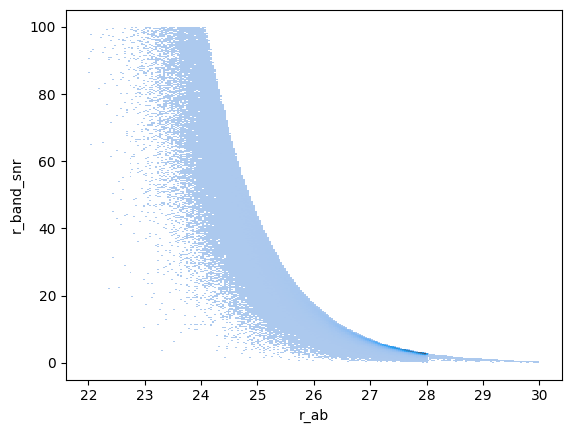

In [ ]:
sns.histplot(
    data=catalog.to_pandas(), x="r_ab", y="r_band_snr", binrange=[(22, 30), (0, 100)]
)

In [ ]:
frac = np.sum(snr < 5) / len(snr) * 100
print(f"Percentage below snr 5 : {frac}")

Percentage below snr 5 : 38.57486645342701


### Isolate snr 10 datalog 

In [ ]:
snr_10_cat = catalog[snr >= 10]

In [ ]:
snr_10_cat.columns

<TableColumns names=('galtileid','ra','dec','redshift','fluxnorm_bulge','fluxnorm_disk','fluxnorm_agn','a_b','a_d','b_b','b_d','pa_bulge','pa_disk','u_ab','g_ab','r_ab','i_ab','z_ab','y_ab','r_band_snr')>

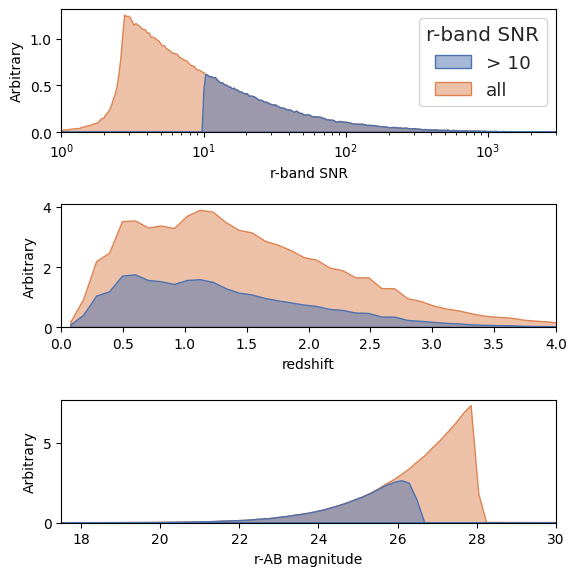

In [ ]:
fig, ax = plt.subplots(3, 1, figsize=(6, 6))
cat_col_names = ["r_band_snr", "redshift", "r_ab"]
fig_col_names = ["r-band SNR", "redshift", "r-AB magnitude"]
xlims = [(1, 3000), (0, 4), (17.5, 30)]
log_scales = [True, False, False]

sns.set(font_scale=1.2)
sns.set_style("whitegrid", rc={"grid.color": ".85", "grid.linestyle": "--"})

for p_num in range(3):

    sns_df = {}

    sns_df["temp"] = list(snr_10_cat[cat_col_names[p_num]])
    sns_df["r-band SNR"] = ["> 10"] * len(snr_10_cat)

    sns_df["temp"].extend(list(catalog[cat_col_names[p_num]]))
    sns_df["r-band SNR"].extend(["all"] * len(catalog))

    if cat_col_names[p_num] == "r_band_snr":
        bins = 500
    else:
        bins = 100

    bins = sns.histplot(
        data=sns_df,
        x="temp",
        hue="r-band SNR",
        bins=bins,
        log_scale=log_scales[p_num],
        alpha=0.5,
        stat="percent",
        ax=ax[p_num],
        element="poly",
    )
    ax[p_num].set_xlim(xlims[p_num])

    ax[p_num].set_ylabel("Arbitrary")
    if p_num > 0:
        ax[p_num].get_legend().remove()

    ax[p_num].set_xlabel(fig_col_names[p_num])

fig.tight_layout()
plt.savefig(
    os.path.join("results", "catalog_distrib.pdf"), format="pdf", bbox_inches="tight"
)

<AxesSubplot:ylabel='Count'>

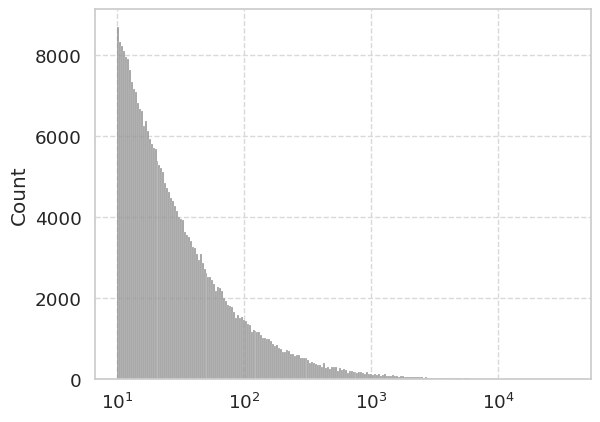

In [ ]:
sns.histplot(snr_10_cat["r_band_snr"], kde=False, log_scale=True, color="0.5")

In [ ]:
snr_10_cat.write(btksims_config["CAT_PATH"], overwrite=True)

In [ ]:
CATSIM_CATALOG_PATH = btksims_config["CAT_PATH"]

_, ext = os.path.splitext(CATSIM_CATALOG_PATH)
fmt = "fits" if ext.lower() == ".fits" else "ascii.basic"
test_catalog = astropy.table.Table.read(CATSIM_CATALOG_PATH, format=fmt)

<AxesSubplot:xlabel='r_ab', ylabel='r_band_snr'>

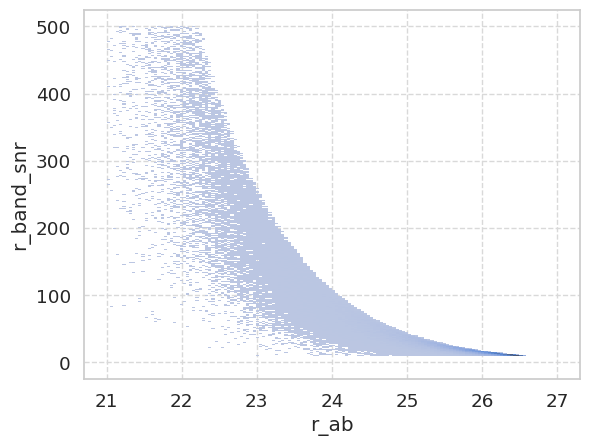

In [ ]:
sns.histplot(
    data=snr_10_cat.to_pandas(), x="r_ab", y="r_band_snr", binrange=[(21, 27), (0, 500)]
)

In [ ]:
snr_10_cat["log_snr"] = np.log10(snr_10_cat["r_band_snr"])

<AxesSubplot:ylabel='Count'>

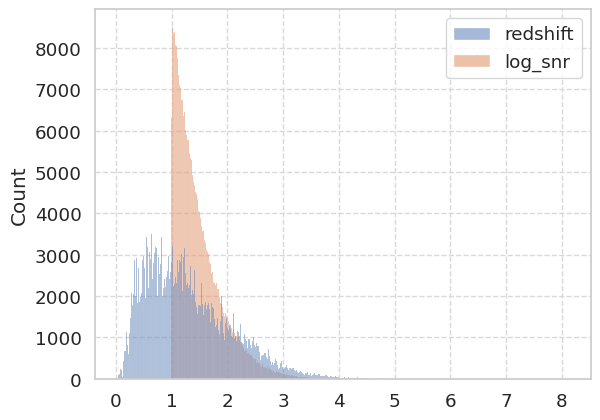

In [ ]:
sns.histplot(snr_10_cat["redshift", "log_snr"].to_pandas())

<AxesSubplot:xlabel='redshift', ylabel='log_snr'>

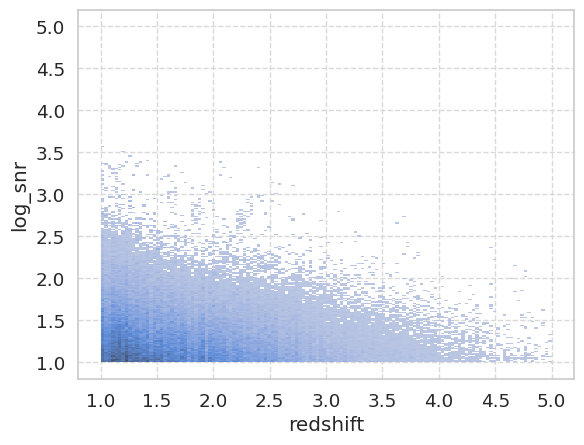

In [ ]:
sns.histplot(
    data=snr_10_cat.to_pandas(), x="redshift", y="log_snr", binrange=[(1, 5), (1, 5)]
)